In [12]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [13]:
client = MongoClient("mongodb://localhost:27017/")
db = client["RetailCustomerDB"]
collection = db["Transactions Collection"]

In [14]:
data = list(collection.find({}, {
    "_id": 0,
    "SaleDate": 1,
    "ProductName": 1,
    "Quantity": 1
}))

df = pd.DataFrame(data)

In [15]:
df["SaleDate"] = pd.to_datetime(df["SaleDate"], errors="coerce")
df = df.dropna(subset=["SaleDate"])
df["YearMonth"] = df["SaleDate"].dt.to_period("M").astype(str)


print("📋 البيانات بعد المعالجة:")
print(df.head())

📋 البيانات بعد المعالجة:
    SaleDate          ProductName  Quantity YearMonth
0 2024-03-10   Lenovo Picture 554         3   2024-03
1 2024-05-25       LG Capital 115         7   2024-05
2 2024-05-10     Canon Anyone 864         8   2024-05
3 2024-03-23  Philips Meeting 273         5   2024-03
4 2025-03-25    Philips World 419         5   2025-03


In [16]:
product_list = sorted(df["ProductName"].dropna().unique())
print("\n🛒 المنتجات المتاحة:")
for i, p in enumerate(product_list, start=1):
    print(f"{i}. {p}")

choice = int(input("\nاختر رقم المنتج للتنبؤ بالطلب القادم: "))
selected_product = product_list[choice - 1]
print(f"\n✅ تم اختيار المنتج: {selected_product}")



🛒 المنتجات المتاحة:
1. Adidas Address 666
2. Adidas American 440
3. Adidas Around 544
4. Adidas Avoid 799
5. Adidas Baby 365
6. Adidas Child 219
7. Adidas Civil 446
8. Adidas Cost 624
9. Adidas Court 671
10. Adidas Detail 101
11. Adidas Director 382
12. Adidas Expect 506
13. Adidas Expert 159
14. Adidas Foot 430
15. Adidas Gas 538
16. Adidas Guy 108
17. Adidas Hundred 498
18. Adidas In 686
19. Adidas It 189
20. Adidas Just 869
21. Adidas Music 540
22. Adidas Necessary 154
23. Adidas Provide 823
24. Adidas Radio 349
25. Adidas Relate 945
26. Adidas Represent 711
27. Adidas Reveal 532
28. Adidas Rule 989
29. Adidas Security 574
30. Adidas Several 391
31. Adidas Sound 197
32. Adidas Suggest 639
33. Adidas Together 645
34. Adidas Up 971
35. Adidas Wait 518
36. Adidas Wall 493
37. Adidas War 528
38. Adidas Wife 113
39. Adidas Without 843
40. Adidas Worry 360
41. Apple Action 109
42. Apple Area 614
43. Apple Audience 478
44. Apple Avoid 948
45. Apple Bag 170
46. Apple Best 381
47. Apple Bil


✅ تم اختيار المنتج: Adidas Baby 365


In [17]:
product_data = (
    df[df["ProductName"] == selected_product]
    .groupby("YearMonth")["Quantity"]
    .sum()
    .reset_index()
)

if product_data.empty:
    print("⚠️ لا توجد بيانات كافية لهذا المنتج.")
    exit()

In [18]:
product_data["t"] = np.arange(len(product_data))
X = product_data[["t"]]
y = product_data["Quantity"]

model = LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [19]:
future_periods = int(input("\n📅 أدخل عدد الشهور المراد التنبؤ بها (مثلاً 3): "))
future_t = np.arange(len(product_data), len(product_data) + future_periods)
future_preds = model.predict(future_t.reshape(-1, 1))

future_dates = pd.date_range(
    start=pd.to_datetime(product_data["YearMonth"].iloc[-1]) + pd.offsets.MonthBegin(),
    periods=future_periods,
    freq="MS"
).strftime("%Y-%m")

future_df = pd.DataFrame({
    "YearMonth": future_dates,
    "PredictedQuantity": np.round(future_preds, 2)
})


C:\Users\C.M™\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [20]:
print("\n🔮 التنبؤ بالطلب للأشهر القادمة:")
print(future_df)


🔮 التنبؤ بالطلب للأشهر القادمة:
  YearMonth  PredictedQuantity
0   2025-11              47.08
1   2025-12              47.09
2   2026-01              47.11
3   2026-02              47.12
4   2026-03              47.14


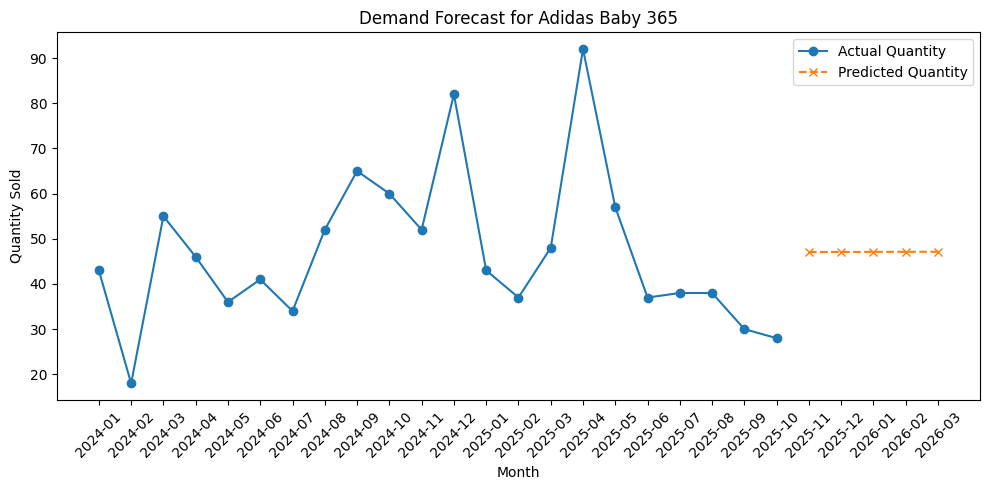

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(product_data["YearMonth"], product_data["Quantity"], label="Actual Quantity", marker='o')
plt.plot(future_df["YearMonth"], future_df["PredictedQuantity"], label="Predicted Quantity", marker='x', linestyle='--')
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.title(f"Demand Forecast for {selected_product}")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
